In [1]:
### TASK 4

from CartPole import CartPole, _remap_angle, remap_angle, _loss, loss
import numpy as np
import matplotlib.pyplot as plt
import sobol_seq
import matplotlib.tri as tri
from scipy.optimize import minimize
import scipy.optimize
import signal
import threading


In [2]:
## function to get total loss using nonlinear policy. adjust no_its, initial_state for different versions
# args is of form [w1, w2, ..., w_total_i, X1, X2, ..., X_total_i, W11, W12, ..., W44]
def total_loss_for_nonlinear_policy(args):

    total_i = 5 # number of basis functions used
    wis = []
    Xis = []
    W = np.zeros((4, 4))

    for i, arg in enumerate(args):
        if i < total_i: # wis
            wis.append(arg)
        elif i < total_i + total_i * 4: # Xis
            if (i+1 - total_i) % 4 == 0:
                Xis.append(np.array([args[i-3], args[i-2], args[i-1], args[i]]))
        else: # W
            m = ((i - total_i*5) // 4)
            n = ((i - total_i*5) % 4)
            W[m, n] = arg

    wis = np.array(wis)
    Xis = np.array(Xis)
        
    # set initial state and no_its: initial state set to something to help get the pole up
    initial_state = [0, 0, np.pi, -10]
    no_its = 10

    # create instance of Cartpole and set initial state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    # initialise loss function value with initial state's loss
    loss_value = pendulum.loss()

    # find accumulated loss of a simulation. no_its - 1 because already done 'first' iteration
    for it in range(no_its-1):

        # run an iteration of simulation with policy as the action
        state = pendulum.getState()
        policy = nonlinear_policy(state, wis, Xis, W)
        pendulum.performAction(policy) # policy = action

        # add to loss value
        loss_value += pendulum.loss()

    return loss_value


# Xis is a 2D arrays of shape i, 4.   wis is a 1D array of length i. W is 4x4 matrix. X is current state
# all need to be np.array
def nonlinear_policy(X, wis, Xis, W):

    # get largest number i can take
    no_is = len(wis)

    policy_val = 0

    # perform summation 
    for i in range(no_is):
        vec = X - Xis[i] # for convenience
        policy_val += wis[i] * np.exp((-0.5) * (vec.T @ W @ vec))
    
    return policy_val




In [3]:
# ###     THIS CELL IS MY ATTEPT TO USING AN OPTIMISATION ALGORITHM

# ## perform optimisation to get smallest possible loss value

# constraints = []
# for i in range(66):
#     constraints.append((-10, 10))

# # result = scipy.optimize.differential_evolution(total_loss_for_nonlinear_policy, constraints, tol=0.5)
# # optimum_value = result.fun
# # optimum_args = result.x



# # Define a callback function to track the best result
# def callback(xk, convergence):
#     # Evaluate the function at the current best solution
#     value = total_loss_for_nonlinear_policy(xk)
#     print("Current best solution:", ', '.join(map(str, xk)))
#     print("Function value:", value)


# # Set the callback function
# callback_func = lambda xk, convergence: callback(xk, convergence)

# # Initialize the best result
# best_result = None

# # Run the optimization with the callback
# result = scipy.optimize.differential_evolution(total_loss_for_nonlinear_policy, constraints, callback=callback_func)

# # Print the best result found so far
# print("Best result found:", best_result)

C:\Users\kailf\AppData\Local\Temp\ipykernel_11224\3373991186.py:61: RuntimeWarning: overflow encountered in exp
  policy_val += wis[i] * np.exp((-0.5) * (vec.T @ W @ vec))
C:\Users\kailf\AppData\Local\Temp\ipykernel_11224\3373991186.py:61: RuntimeWarning: invalid value encountered in double_scalars
  policy_val += wis[i] * np.exp((-0.5) * (vec.T @ W @ vec))


min loss index:  38 min loss value:  0.5598539425107472
min loss index:  131 min loss value:  0.5135473753206109
min loss index:  131 min loss value:  0.5135473753206109
min loss index:  271 min loss value:  0.5101261338401443
min loss index:  271 min loss value:  0.5101261338401443
min loss index:  271 min loss value:  0.5101261338401443
min loss index:  643 min loss value:  0.47979758485290336
min loss index:  643 min loss value:  0.47979758485290336
min loss index:  643 min loss value:  0.47979758485290336
min loss index:  2499 min loss value:  0.3052151786837498
min loss index:  2499 min loss value:  0.3052151786837498
min loss index:  2499 min loss value:  0.3052151786837498
min loss index:  2499 min loss value:  0.3052151786837498
min loss index:  2499 min loss value:  0.3052151786837498


C:\Users\kailf\AppData\Local\Temp\ipykernel_11224\3373991186.py:61: RuntimeWarning: overflow encountered in double_scalars
  policy_val += wis[i] * np.exp((-0.5) * (vec.T @ W @ vec))


min loss index:  2499 min loss value:  0.3052151786837498


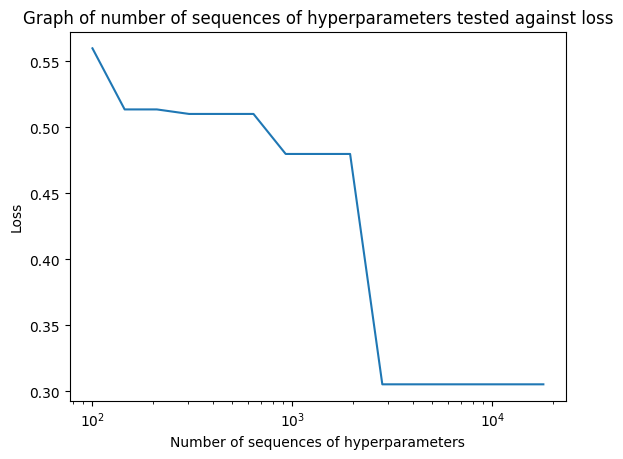

In [13]:
### THIS CELL IS MY ATTEMPT TO GET AN APPROXIMATE OPTIMAL SOLUTION BY RANDOM GUESSES
#initial_args_to_try = sobol_seq.i4_sobol_generate(66, no_combinations)


##  USING 5 BASIS FUNCTIONS, USING SIG=10 IN CARTPOLE

# range of args is the range of values we set the sobol sequence to
def get_optimal_args_course(num_of_combinations_to_try_course, range_of_args=5):

    ## get course approx
    args_to_try_without_last_bit = sobol_seq.i4_sobol_generate(40, int(num_of_combinations_to_try_course//1))

    args_to_try_course = np.zeros((int(num_of_combinations_to_try_course//1), 41))
    for i, arg in enumerate(args_to_try_without_last_bit):
        args_to_try_course[i] = np.append(arg, 0.5) # adjust this if changing range of components of arg to try

    args_to_try_course -= 0.5 # to get values between -0.5 and 0.5
    args_to_try_course *= range_of_args # 5: to get values between -2.5 and 2.5

    lst_of_losses = []

    for arg in args_to_try_course:

        loss_value = total_loss_for_nonlinear_policy(arg)
        lst_of_losses.append(loss_value)


    # get index of minimum loss value
    min_loss_index = lst_of_losses.index(min(lst_of_losses))
    print("min loss index: ", min_loss_index, "min loss value: ", lst_of_losses[min_loss_index])

    # min_loss_sln is the optimum solution found
    min_loss_sln_course = args_to_try_course[min_loss_index]

    return min_loss_sln_course, lst_of_losses[min_loss_index]


def get_optimal_args_fine(min_loss_sln_course, num_of_combinations_to_try_fine):

    ## get fine approx

    args_to_try_without_last_bit = sobol_seq.i4_sobol_generate(40, num_of_combinations_to_try_fine)

    args_to_try_fine = np.zeros((num_of_combinations_to_try_fine, 41))
    for i, arg in enumerate(args_to_try_without_last_bit):
        args_to_try_fine[i] = np.append(arg, 0.5) # adjust this if changing range of components of arg to try

    args_to_try_fine -= 0.5 # to get values between -0.5 and 0.5
    args_to_try_fine *= 1 # to get values between -0.5 and 0.5

    lst_of_losses = []

    for arg in args_to_try_fine:
        arg += np.array(min_loss_sln_course) # add the fine sobol sequence to the previously found optimal value
        loss_value = total_loss_for_nonlinear_policy(arg)
        lst_of_losses.append(loss_value)


    # get index of minimum loss value
    min_loss_index = lst_of_losses.index(min(lst_of_losses))
    print("min loss index: ", min_loss_index, "min loss value: ", lst_of_losses[min_loss_index])

    # min_loss_sln is the optimum solution found
    min_loss_sln_fine = args_to_try_fine[min_loss_index]

    return min_loss_sln_fine




# define function to plot scans of loss value against range of values tried
def plot_scans_of_range_of_args_against_loss(list_of_ranges, num_of_combs):

    losses_to_plot = []
    
    

    for a_range in list_of_ranges:
        optiamal_sln, optimal_function_val = get_optimal_args_course(num_of_combs, a_range)
        losses_to_plot.append(optimal_function_val)

        if optimal_function_val < 0.2:
            actual_optimal_sln = optiamal_sln


    plt.plot(list_of_ranges, losses_to_plot)
    plt.xscale('log')
    plt.xlabel('Range of hyperparameters')
    plt.ylabel('Loss')
    plt.title("Graph of ranges of hyperparameters tested against loss")

    plt.show()

    #return actual_optimal_sln



# define function to plot scans of number of datapoints agaisnt range of values tried
def plot_scans_of_no_datapoints_against_loss(list_of_no_datapoints, range_of_args=2.5):

    losses_to_plot = []

    for no_datapoints in list_of_no_datapoints:
        optiamal_sln, optimal_function_val = get_optimal_args_course(no_datapoints, range_of_args=range_of_args)
        losses_to_plot.append(optimal_function_val)

    plt.plot(list_of_no_datapoints, losses_to_plot)
    plt.xscale('log')
    plt.xlabel('Number of sequences of hyperparameters')
    plt.ylabel('Loss')
    plt.title("Graph of number of sequences of hyperparameters tested against loss")

    plt.show()


list_of_ranges = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8, 25.6]
list_of_ranges = np.logspace(np.log2(0.1), np.log2(60), num=20, base=2)
num_of_combs = 1000
#opt_sln = plot_scans_of_range_of_args_against_loss(list_of_ranges, num_of_combs)

list_of_no_datapoints = [200, 400, 600, 800, 1600, 3200, 6400]
list_of_no_datapoints = np.logspace(np.log2(100), np.log2(18000), num=15, base=2)
range_of_args = 3
plot_scans_of_no_datapoints_against_loss(list_of_no_datapoints, range_of_args=2.5)




    

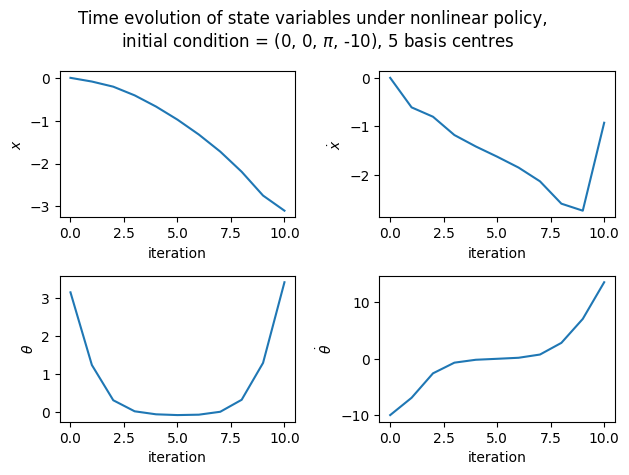

In [10]:
### ROLLOUTS

# function to plot time evolution of variables under policy
def plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, no_its, args, total_i):

    ## convert args into individual arguments
    wis = []
    Xis = []
    W = np.zeros((4, 4))

    for i, arg in enumerate(args):
        if i < total_i: # wis
            wis.append(arg)
        elif i < total_i + total_i * 4: # Xis
            if (i+1 - total_i) % 4 == 0:
                Xis.append(np.array([args[i-3], args[i-2], args[i-1], args[i]]))
        else: # W
            m = ((i - total_i*5) // 4)
            n = ((i - total_i*5) % 4)
            W[m, n] = arg

    wis = np.array(wis)
    Xis = np.array(Xis)


    # initialise pendulum with current state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    # initialise lists for data to plot
    xs, xdots, thetas, thetadots = [initial_state[0]], [initial_state[1]], [initial_state[2]], [initial_state[3]]

    # create list for x axis
    iteration_list = list(range(no_its+1))

    state = initial_state

    # run no_its simulations
    for it in range(no_its):
        
        # tun one iteration
        policy = nonlinear_policy(state, wis, Xis, W)
        #policy = 0
        pendulum.performAction(policy)
        state = pendulum.getState()

        # append state variables to lists to plot
        xs.append(state[0])
        xdots.append(state[1])
        thetas.append(state[2])
        thetadots.append(state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, xs)
    plt.xlabel('iteration')
    plt.ylabel('$x$')

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, xdots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, thetas)
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, thetadots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    #plt.suptitle('Time evolution of state variables with no policy applied, \n initial condition = (0, 0, $\pi$, -10)')
    plt.suptitle('Time evolution of state variables under nonlinear policy, \n initial condition = (0, 0, $\pi$, -10), 5 basis centres')
    plt.tight_layout()
    plt.show()




# course_optimal, loss_at_optimal = get_optimal_args_course(10000)
# fine_optimal = get_optimal_args_fine(course_optimal, 1000)

# print(course_optimal, fine_optimal)
# args = fine_optimal # from previous cell



initial_state = np.array([0, 0, np.pi, -10]) # is equal to the initial state the policy was optimised for
no_its = 10

args = opt_sln
plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, no_its, args, total_i=5)



[-0.28657671 -0.41239087  0.04892773 -0.04293658 -0.16875075  0.16275959
 -0.49027583  0.14478614  0.25662096 -0.18472715  0.44434368 -0.31253836
  0.02496313 -0.37444692 -0.13679794 -0.2066947  -0.15277434  0.22866225
 -0.48628173  0.03295133  0.36246462  0.2426416  -0.21268585 -0.14278909
  0.36845577  0.41239087 -0.06690118  0.08687169 -0.178736   -0.34848527
 -0.07289233 -0.1947124  -0.22067405  0.2226711  -0.43036433  0.02496313
  0.11882449  0.05092478  0.35647347  0.02696018  0.        ]


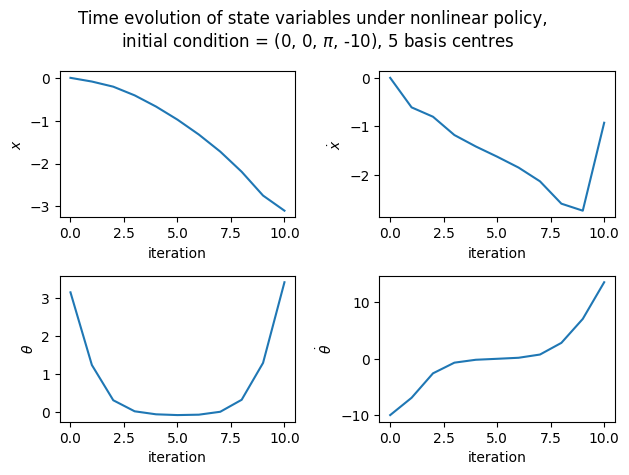

In [20]:
print(args)
dontforgetarg = args

# print("current loss", total_loss_for_nonlinear_policy(dontforgetarg))

# maybeevenbetter = get_optimal_args_fine(dontforgetarg, num_of_combinations_to_try_fine=20000)

# print("final loss", total_loss_for_nonlinear_policy(maybeevenbetter))
initial_state = np.array([0, 0, np.pi, -10])

plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, no_its, dontforgetarg, total_i=5)

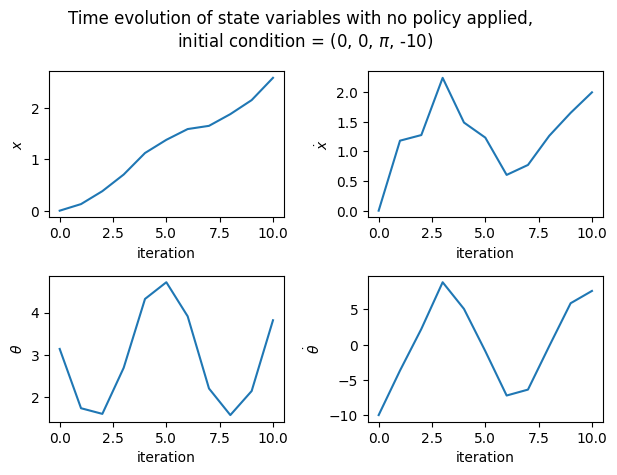

In [21]:
# function to plot time evolution of variables under policy
def plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, no_its, args, total_i):

    ## convert args into individual arguments
    wis = []
    Xis = []
    W = np.zeros((4, 4))

    for i, arg in enumerate(args):
        if i < total_i: # wis
            wis.append(arg)
        elif i < total_i + total_i * 4: # Xis
            if (i+1 - total_i) % 4 == 0:
                Xis.append(np.array([args[i-3], args[i-2], args[i-1], args[i]]))
        else: # W
            m = ((i - total_i*5) // 4)
            n = ((i - total_i*5) % 4)
            W[m, n] = arg

    wis = np.array(wis)
    Xis = np.array(Xis)


    # initialise pendulum with current state
    pendulum = CartPole()
    pendulum.setState(initial_state)

    # initialise lists for data to plot
    xs, xdots, thetas, thetadots = [initial_state[0]], [initial_state[1]], [initial_state[2]], [initial_state[3]]

    # create list for x axis
    iteration_list = list(range(no_its+1))

    state = initial_state

    # run no_its simulations
    for it in range(no_its):
        
        # tun one iteration
        policy = nonlinear_policy(state, wis, Xis, W)
        policy = 0
        pendulum.performAction(policy)
        state = pendulum.getState()

        # append state variables to lists to plot
        xs.append(state[0])
        xdots.append(state[1])
        thetas.append(state[2])
        thetadots.append(state[3])

    
    # plots
    plt.subplot(2, 2, 1)
    plt.plot(iteration_list, xs)
    plt.xlabel('iteration')
    plt.ylabel('$x$')

    plt.subplot(2, 2, 2)
    plt.plot(iteration_list, xdots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{x}$')

    plt.subplot(2, 2, 3)
    plt.plot(iteration_list, thetas)
    plt.xlabel('iteration')
    plt.ylabel(r'$\theta$')

    plt.subplot(2, 2, 4)
    plt.plot(iteration_list, thetadots)
    plt.xlabel('iteration')
    plt.ylabel(r'$\dot{\theta}$')


    plt.suptitle('Time evolution of state variables with no policy applied, \n initial condition = (0, 0, $\pi$, -10)')
    #plt.suptitle('Time evolution of state variables under nonlinear policy, \n initial condition = (0, 0, $\pi$, -10), 5 basis centres')
    plt.tight_layout()
    plt.show()

initial_state = np.array([0, 0, np.pi, -10])
plot_time_evolution_of_state_variables_using_real_dynamics_under_policy(initial_state, no_its, args, total_i=5)